In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import bambi as bmb
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm

pd.set_option('display.max_columns', None)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Research Question 1: How well can we predict the winner of basketball games using key categorical and numerical data (# assists, conference, win percentage etc.)?

_We are essentially trying to predict a binary variable that indicates whether or not the home team wins. Our dataset consists of a variety of different potential features. We have numerical features such as different scoring metrics (FGs, FTs, 3PTs) and W/L records. We also have different categorical features such as the home team's conference or the season in which the game was played._

## Loading and Cleaning up the data

We have 5 distinct datasets available:
- **TEAMS**: information about the different franchises, e.g. city, stadium name, etc.
- **PLAYERS**: information about various players and the teams that they played for.
- **GAMES**: information about each of the games played from the years 2003-2022, e.g. which teams played, number of assists made.
- **GAMES DETAILS**: statistics of each of the players in each of the games, e.g. number of minutes played, offensive rebounds.
- **RANKINGS**: the win/loss numbers for all teams at various dates.

In [2]:
# loading the data
datasets = {}
for file_name in os.listdir('archive'):
    if file_name.endswith('.csv'):
        datasets[file_name.split('.')[0]] = pd.read_csv('archive/' + file_name, low_memory=False)

list(datasets.keys())

['teams', 'players', 'games', 'ranking', 'games_details']

_Now we clean up the datasets, keeping only potentially relevant information and converting them into a format that works for us._

In [3]:
# printing the shape of each dataset
for name, df in datasets.items():
    print(name, df.shape)

teams (30, 14)
players (7228, 4)
games (26651, 21)
ranking (210342, 13)
games_details (668628, 29)


In [4]:
# calculating the number of missing values in each dataset
for key, value in datasets.items():
    print(key)
    print(value.isna().sum())

teams
LEAGUE_ID             0
TEAM_ID               0
MIN_YEAR              0
MAX_YEAR              0
ABBREVIATION          0
NICKNAME              0
YEARFOUNDED           0
CITY                  0
ARENA                 0
ARENACAPACITY         4
OWNER                 0
GENERALMANAGER        0
HEADCOACH             0
DLEAGUEAFFILIATION    0
dtype: int64
players
PLAYER_NAME    0
TEAM_ID        0
PLAYER_ID      0
SEASON         0
dtype: int64
games
GAME_DATE_EST        0
GAME_ID              0
GAME_STATUS_TEXT     0
HOME_TEAM_ID         0
VISITOR_TEAM_ID      0
SEASON               0
TEAM_ID_home         0
PTS_home            99
FG_PCT_home         99
FT_PCT_home         99
FG3_PCT_home        99
AST_home            99
REB_home            99
TEAM_ID_away         0
PTS_away            99
FG_PCT_away         99
FT_PCT_away         99
FG3_PCT_away        99
AST_away            99
REB_away            99
HOME_TEAM_WINS       0
dtype: int64
ranking
TEAM_ID               0
LEAGUE_ID             

In [5]:
# cleaning each dataset in the dictionary, keeping only relevant columns

# filling missing values with the mean for stadiums capacity
datasets['teams'] = datasets['teams'][['TEAM_ID', 'ABBREVIATION', 'NICKNAME', 'CITY', 'ARENACAPACITY']].fillna(0).replace(0, datasets['teams']["ARENACAPACITY"].mean().round(0))

# dropping missing values and converting the minutes played into a float
datasets['game_details'] = datasets['games_details'][["GAME_ID", "TEAM_ID", "MIN", "FG_PCT", "FG3_PCT", "FT_PCT", 
                                                    "OREB", "DREB", "REB", "AST", "STL", "BLK", "TO", "PF", "PTS", "PLUS_MINUS"]].dropna()
datasets['game_details']['MIN'] = datasets['game_details']['MIN'].str.split(':').apply(lambda x: float(x[0]) + float(x[1])/60).round(3)

# converting the date into a datetime object
datasets['ranking'] = datasets['ranking'][["TEAM_ID", "SEASON_ID", "STANDINGSDATE", "CONFERENCE", "G", "W_PCT"]]
datasets['ranking']["STANDINGSDATE"] = pd.to_datetime(datasets['ranking']["STANDINGSDATE"])

# converting the date into a datetime object
datasets['games'] = datasets['games'].drop(['GAME_STATUS_TEXT', "TEAM_ID_home", "TEAM_ID_away"], axis=1)
datasets['games']["GAME_DATE_EST"] = pd.to_datetime(datasets['games']["GAME_DATE_EST"])

## Data Preprocessing

_In this section, we consolidate information from the datasets into one dataset that we can use for our modeling purposes. Primarily, we combine information from the 'games' and 'rankings' datasets. We take the team statistics (ASTs, REBs, FG_PCT) from the games dataset, and the win percentage and conference from the rankings dataset. We do this for both away and home teams. We then prepare our dataset, keeping only features that we deem to be useful during the modeling process. We process these, standarizing all numerical data to mitigate bias and one hot encode all categorical data. Next, using domain knowledge and the different correlation values, we perform a preliminary feature engineering and keep features we see as informative into prediciting the winner of the game. This process removed features such as the season in which the game was played, as the datapoints were equally distributed amongst all the seasons. We also removed the number of points for each team, as this was too strongly correlated with our target variable, which would have caused our models to overfit._

In [6]:
# combining the win percentage of the home and away team based on the date of the game
# home teams
datasets['games'] = datasets['games'].merge(datasets['ranking'], left_on=['HOME_TEAM_ID', 'GAME_DATE_EST'], right_on=['TEAM_ID', 'STANDINGSDATE'], how='left', suffixes=('', '_home_ranking')).rename(columns={'W_PCT': 'HOME_TEAM_W_PCT', 'CONFERENCE': 'HOME_TEAM_CONFERENCE'}).drop(['TEAM_ID', 'STANDINGSDATE', 'G'], axis=1)

# away teams
datasets['games'] = datasets['games'].merge(datasets['ranking'], left_on=['VISITOR_TEAM_ID', 'GAME_DATE_EST'], right_on=['TEAM_ID', 'STANDINGSDATE'], how='left', suffixes=('', '_away_ranking')).rename(columns={'W_PCT': 'VISITOR_TEAM_W_PCT', 'CONFERENCE': 'VISITOR_TEAM_CONFERENCE'}).drop(['TEAM_ID', 'STANDINGSDATE', 'G', 'SEASON_ID_away_ranking', 'SEASON_ID'], axis=1)

# creating a new column for the difference in win percentage between the home and away team
datasets['games']['W_PCT_DIFF'] = datasets['games']['HOME_TEAM_W_PCT'] - datasets['games']['VISITOR_TEAM_W_PCT']

# fixing data type for the season year for possible ohe later
datasets['games']['SEASON'] = datasets['games']['SEASON'].astype('str')

# replacing nan values with the average for that column
datasets['games'].fillna(datasets['games'].select_dtypes(include=['float64', 'int64']).mean(), inplace=True)

datasets['games'].head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,HOME_TEAM_CONFERENCE,HOME_TEAM_W_PCT,VISITOR_TEAM_CONFERENCE,VISITOR_TEAM_W_PCT,W_PCT_DIFF
0,2022-12-22,22200477,1610612740,1610612759,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,0.478,0.815,0.321,23.0,44.0,1,West,0.613,West,0.323,0.290
1,2022-12-22,22200478,1610612762,1610612764,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,0.561,0.765,0.333,20.0,37.0,1,West,0.543,East,0.364,0.179
2,2022-12-21,22200466,1610612739,1610612749,2022,114.0,0.482,0.786,0.313,22.0,37.0,106.0,0.470,0.682,0.433,20.0,46.0,1,East,0.667,East,0.710,-0.043
3,2022-12-21,22200467,1610612755,1610612765,2022,113.0,0.441,0.909,0.297,27.0,49.0,93.0,0.392,0.735,0.261,15.0,46.0,1,East,0.600,East,0.235,0.365
4,2022-12-21,22200468,1610612737,1610612741,2022,108.0,0.429,1.000,0.378,22.0,47.0,110.0,0.500,0.773,0.292,20.0,47.0,0,East,0.500,East,0.419,0.081


_After the merging, we can remove the irrelevant information that may sway our model, such as the unique identifiers for the teams and the dates that were useful during our merging process._

In [7]:
# now we can drop the columns we don't need i.e. the identifiers and the win percentages
df = datasets['games'].copy().drop(['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'GAME_DATE_EST', 'HOME_TEAM_W_PCT', 'VISITOR_TEAM_W_PCT'], axis=1)
df.head()

,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,HOME_TEAM_CONFERENCE,VISITOR_TEAM_CONFERENCE,W_PCT_DIFF
0,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,0.478,0.815,0.321,23.0,44.0,1,West,West,0.290
1,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,0.561,0.765,0.333,20.0,37.0,1,West,East,0.179
2,2022,114.0,0.482,0.786,0.313,22.0,37.0,106.0,0.470,0.682,0.433,20.0,46.0,1,East,East,-0.043
3,2022,113.0,0.441,0.909,0.297,27.0,49.0,93.0,0.392,0.735,0.261,15.0,46.0,1,East,East,0.365
4,2022,108.0,0.429,1.000,0.378,22.0,47.0,110.0,0.500,0.773,0.292,20.0,47.0,0,East,East,0.081


In [8]:
# before standardizing, we take the deltas of the numerical columns
# the two features on their own are not very useful, but the difference between them is
df['FG_PCT_DIFF'] = df['FG_PCT_home'] - df['FG_PCT_away']
df['FT_PCT_DIFF'] = df['FT_PCT_home'] - df['FT_PCT_away']
df['FG3_PCT_DIFF'] = df['FG3_PCT_home'] - df['FG3_PCT_away']
df['AST_DIFF'] = df['AST_home'] - df['AST_away']
df['REB_DIFF'] = df['REB_home'] - df['REB_away']
df.drop(['FG_PCT_home', 'FG_PCT_away', 'FT_PCT_home', 'FT_PCT_away', 'FG3_PCT_home', 'FG3_PCT_away', 'AST_home', 'AST_away', 'REB_home', 'REB_away'], axis=1, inplace=True)

# now we can standardize the numerical variables and one hot encode the categorical variables
categorical_columns = ['SEASON', 'HOME_TEAM_CONFERENCE', 'VISITOR_TEAM_CONFERENCE']
numerical_columns = ['PTS_home', 'FG_PCT_DIFF', 'FT_PCT_DIFF', 'FG3_PCT_DIFF', 'AST_DIFF', 'REB_DIFF', 'PTS_away', 'W_PCT_DIFF']
target_column = df.pop('HOME_TEAM_WINS')

scaler = StandardScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# applying the transformations to the dataframe
transformer = ColumnTransformer([('scaler', scaler, numerical_columns), ('ohe', ohe, categorical_columns)], remainder='passthrough')
transformed_df = transformer.fit_transform(df)

# converting the transformed data back to a df
ohe_columns = transformer.named_transformers_['ohe'].get_feature_names_out(input_features=categorical_columns)
all_columns = numerical_columns + list(ohe_columns)
transformed_df = pd.DataFrame(transformed_df, columns=all_columns)
df_transformed = pd.concat([transformed_df, target_column], axis=1)

df_transformed.head()

,PTS_home,FG_PCT_DIFF,FT_PCT_DIFF,FG3_PCT_DIFF,AST_DIFF,REB_DIFF,PTS_away,W_PCT_DIFF,SEASON_2003,SEASON_2004,SEASON_2005,SEASON_2006,SEASON_2007,SEASON_2008,SEASON_2009,SEASON_2010,SEASON_2011,SEASON_2012,SEASON_2013,SEASON_2014,SEASON_2015,SEASON_2016,SEASON_2017,SEASON_2018,SEASON_2019,SEASON_2020,SEASON_2021,SEASON_2022,HOME_TEAM_CONFERENCE_East,HOME_TEAM_CONFERENCE_West,VISITOR_TEAM_CONFERENCE_East,VISITOR_TEAM_CONFERENCE_West,HOME_TEAM_WINS
0,1.699190,-0.064675,0.774221,0.349192,0.099527,0.082466,1.218498,0.918867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1
1,1.246794,-1.083535,1.311671,0.753211,-0.789078,0.193970,0.845829,0.555849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1
2,0.794397,0.012706,0.724719,-0.811560,0.099527,-1.144078,0.398626,-0.170187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1
3,0.718998,0.489893,1.219739,0.188867,1.580535,0.193970,-0.570313,1.164149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1
4,0.342001,-1.057741,1.594540,0.509517,0.099527,-0.140542,0.696761,0.235347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0


In [9]:
# counting the number of datapoints for all seasons 2003-2022
season_columns = [col for col in df_transformed.columns if col.startswith('SEASON_')]
season_counts = df_transformed[season_columns].sum(axis=0).sort_values(ascending=False)
season_counts / len(df_transformed)

SEASON_2005    0.053691
SEASON_2013    0.053504
SEASON_2008    0.053429
SEASON_2009    0.053391
SEASON_2010    0.053316
SEASON_2012    0.053241
SEASON_2006    0.053204
SEASON_2014    0.053166
SEASON_2015    0.053091
SEASON_2007    0.052904
SEASON_2016    0.052679
SEASON_2021    0.052079
SEASON_2003    0.051929
SEASON_2017    0.051817
SEASON_2018    0.051667
SEASON_2004    0.051067
SEASON_2020    0.047580
SEASON_2019    0.046530
SEASON_2011    0.041393
SEASON_2022    0.020322
dtype: float64

_The season statistics are somewhat equal for all seasons, thus they do not seem statistically significant, so we can drop these._

In [10]:
# dropping the season columns
df_transformed.drop(season_columns, axis=1, inplace=True)
df_transformed.head()

# also drop the points scored by the home team and the away team as they are highly correlated with the target variable
df_transformed.drop(['PTS_home', 'PTS_away'], axis=1, inplace=True)

In [11]:
df_transformed.corr()['HOME_TEAM_WINS'].sort_values(ascending=False)

HOME_TEAM_WINS                  1.000000
FG_PCT_DIFF                     0.625849
W_PCT_DIFF                      0.482869
AST_DIFF                        0.455549
FG3_PCT_DIFF                    0.418125
REB_DIFF                        0.365605
FT_PCT_DIFF                     0.145089
HOME_TEAM_CONFERENCE_West       0.041981
VISITOR_TEAM_CONFERENCE_East    0.035941
VISITOR_TEAM_CONFERENCE_West   -0.035941
HOME_TEAM_CONFERENCE_East      -0.041981
Name: HOME_TEAM_WINS, dtype: float64

In [12]:
# our final dataset for modeling
df_transformed.head(5)

,FG_PCT_DIFF,FT_PCT_DIFF,FG3_PCT_DIFF,AST_DIFF,REB_DIFF,W_PCT_DIFF,HOME_TEAM_CONFERENCE_East,HOME_TEAM_CONFERENCE_West,VISITOR_TEAM_CONFERENCE_East,VISITOR_TEAM_CONFERENCE_West,HOME_TEAM_WINS
0,-0.064675,0.774221,0.349192,0.099527,0.082466,0.918867,0.0,1.0,0.0,1.0,1
1,-1.083535,1.311671,0.753211,-0.789078,0.193970,0.555849,0.0,1.0,1.0,0.0,1
2,0.012706,0.724719,-0.811560,0.099527,-1.144078,-0.170187,1.0,0.0,1.0,0.0,1
3,0.489893,1.219739,0.188867,1.580535,0.193970,1.164149,1.0,0.0,1.0,0.0,1
4,-1.057741,1.594540,0.509517,0.099527,-0.140542,0.235347,1.0,0.0,1.0,0.0,0


## Modeling

_In this section, we use our dataset to predict our target variable, whether the home team wins or not. We use two kinds of models, GLMs and non-parametric models. For GLMs, we use a Frequentist and a Bayesian approach, comparing between the two. For non-parametric methods, we use a Random Forest and a Neural Network. All models use similar features. We determined these through feature engineering and domain knowledge. These features were descriptive enough to allow the model to make connections, but not too descriptive that causes our model to overfit. Overfitting was something we were struggling with, which was a product of using points, which directly correlates to whether the team wins or not._

### GLMs

_We used both a Frequentist and a Bayesian approach._

#### Frequentist GLM

_For the Frequentist GLM, we made a logistic regression-based GLM as we simply wanted to produce a binary classification, i.e. 1 if the home teams wins and 0 if the away team wins. We made two different models, one with using the metrics for both teams (FT_PCT away and home) and the other with the difference of the metrics of the two teams (i.e. FT_PCT_HOME - FT_PCT_AWAY). We trained the model by splitting the dataset into train and test set and measured results between the two models using the AIC, BIC, and the RMSE._

In [13]:
# adding a constant and then splitting the data into train and test sets
X = sm.add_constant(df_transformed.drop('HOME_TEAM_WINS', axis=1))
y = df_transformed['HOME_TEAM_WINS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
frequentist_model_1 = sm.Logit(y_train, X_train).fit()
frequentist_model_1.summary()

Optimization terminated successfully.
         Current function value: 0.280475
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         HOME_TEAM_WINS   No. Observations:                18669
Model:                          Logit   Df Residuals:                    18658
Method:                           MLE   Df Model:                           10
Date:                Sat, 09 Dec 2023   Pseudo R-squ.:                  0.5871
Time:                        21:47:22   Log-Likelihood:                -5236.2
converged:                       True   LL-Null:                       -12682.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.4388        nan        nan        nan         nan         nan
FG_PCT_DIFF                      1.9815      0.044     45.489      0.000       1.896       2.067
FT_PCT_DIFF                      0.5843      0.027     21.837      0.000       0.532       0.637
FG3_PCT_DIFF                     0.7907      0.030     26.314      0.000       0.732       0.850
AST_DIFF                         0.4158      0.032     12.896      0.000       0.353       0.479
REB_DIFF                         0.8307      0.029     28.854      0.000       0.774       0.887
W_PCT_DIFF                       1.4582      0.037     39.092      0.000       1.385       1.531
HOME_TEAM_CONFERENCE_East        0.2062   8.79e+05   2.35e-07      1.000   -1.72e+06    1.72e+06
HOME_TEAM_CONFERENCE_West        0.2327   8.79e+05   2.65e-07      1.000   -1.72e+06    1.72e+06
VISITOR_TEAM_CONFERENCE_East     0.2166      0.044      4.927      0.000       0.130       0.303
VISITOR_TEAM_CONFERENCE_West     0.2222      0.009     25.274      0.000       0.205       0.239
================================================================================================
"""

In [15]:
# all my evaluation metrics
y_pred_frequentist_1 = frequentist_model_1.predict(X_test)
y_pred_frequentist_1 = np.where(y_pred_frequentist_1 > 0.5, 1, 0)
rmse_frequentist_1 = np.sqrt(np.mean((y_pred_frequentist_1 - y_test)**2))
acc_freq_1 = accuracy_score(y_test, y_pred_frequentist_1)
aic_freq_1 = frequentist_model_1.aic
bic_freq_1 = frequentist_model_1.bic

In [16]:
print(f'{"Testing RMSE:":<20} {rmse_frequentist_1:.4f}')
print(f'{"AIC:":<20} {aic_freq_1:.4f}')
print(f'{"BIC:":<20} {bic_freq_1:.4f}')
print(f'{"Accuracy:":<20} {acc_freq_1:.2%}')
print(f'{"Classification Report":=^40}')
print(classification_report(y_test, y_pred_frequentist_1))

Testing RMSE:        0.3553
AIC:                 10494.3825
BIC:                 10580.5634
Accuracy:            87.38%
=========Classification Report==========
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      3230
           1       0.89      0.90      0.89      4772

    accuracy                           0.87      8002
   macro avg       0.87      0.87      0.87      8002
weighted avg       0.87      0.87      0.87      8002



#### Bayesian GLM

_Next, we used a Bayesian approach. We chose the priors defined in our model below as we have a weak understanding of our data, i.e. we do not have much information about which team wins based on looking at our features. We also want our dataset to inform our posterior distribution as much as possible and not let stricter priors limit this._

In [17]:
# renaming the columns for the pymc model
df_bay = df_transformed.copy().rename(columns={'FG_PCT_DIFF': 'fg', 'FT_PCT_DIFF': 'ft', 
                                        'FG3_PCT_DIFF': 'fg3', 'AST_DIFF': 'ast', 
                                        'REB_DIFF': 'reb', 'W_PCT_DIFF': 'w_pct',
                                        'HOME_TEAM_WINS': 'win', 
                                        'HOME_TEAM_CONFERENCE_East': 'h_east',
                                        'HOME_TEAM_CONFERENCE_West': 'h_west', 
                                        'VISITOR_TEAM_CONFERENCE_East': 'v_east',
                                        'VISITOR_TEAM_CONFERENCE_West': 'v_west'}).sample(frac=0.05, random_state=42)
df_bay.head()

,fg,ft,fg3,ast,reb,w_pct,h_east,h_west,v_east,v_west,win
24985,-0.219439,-2.309044,0.996905,-0.492876,0.974497,1.605657,0.0,1.0,0.0,1.0,1
7893,0.090088,0.017548,0.208106,-1.085279,-0.475054,-1.138234,1.0,0.0,1.0,0.0,0
9212,0.683348,-1.517013,-0.490910,-0.492876,-0.363550,-0.248677,1.0,0.0,0.0,1.0,0
20347,0.515687,-0.512830,0.394083,0.543830,-1.255582,0.402139,0.0,1.0,1.0,0.0,0
8616,-1.057741,-0.675479,0.394083,-0.640977,-1.924605,-0.327167,1.0,0.0,1.0,0.0,0


In [18]:
df_bay.shape

(1334, 11)

In [19]:
bayesian_model = bmb.Model('win ~ fg + ft + fg3 + ast + reb + w_pct + h_east + h_west + v_east + v_west', df_bay, family='bernoulli')
bay_results = bayesian_model.fit(draws=500, chains=2, target_accept=0.95)

Modeling the probability that win==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Intercept, fg, ft, fg3, ast, reb, w_pct, h_east, h_west, v_east, v_west]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 7830 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


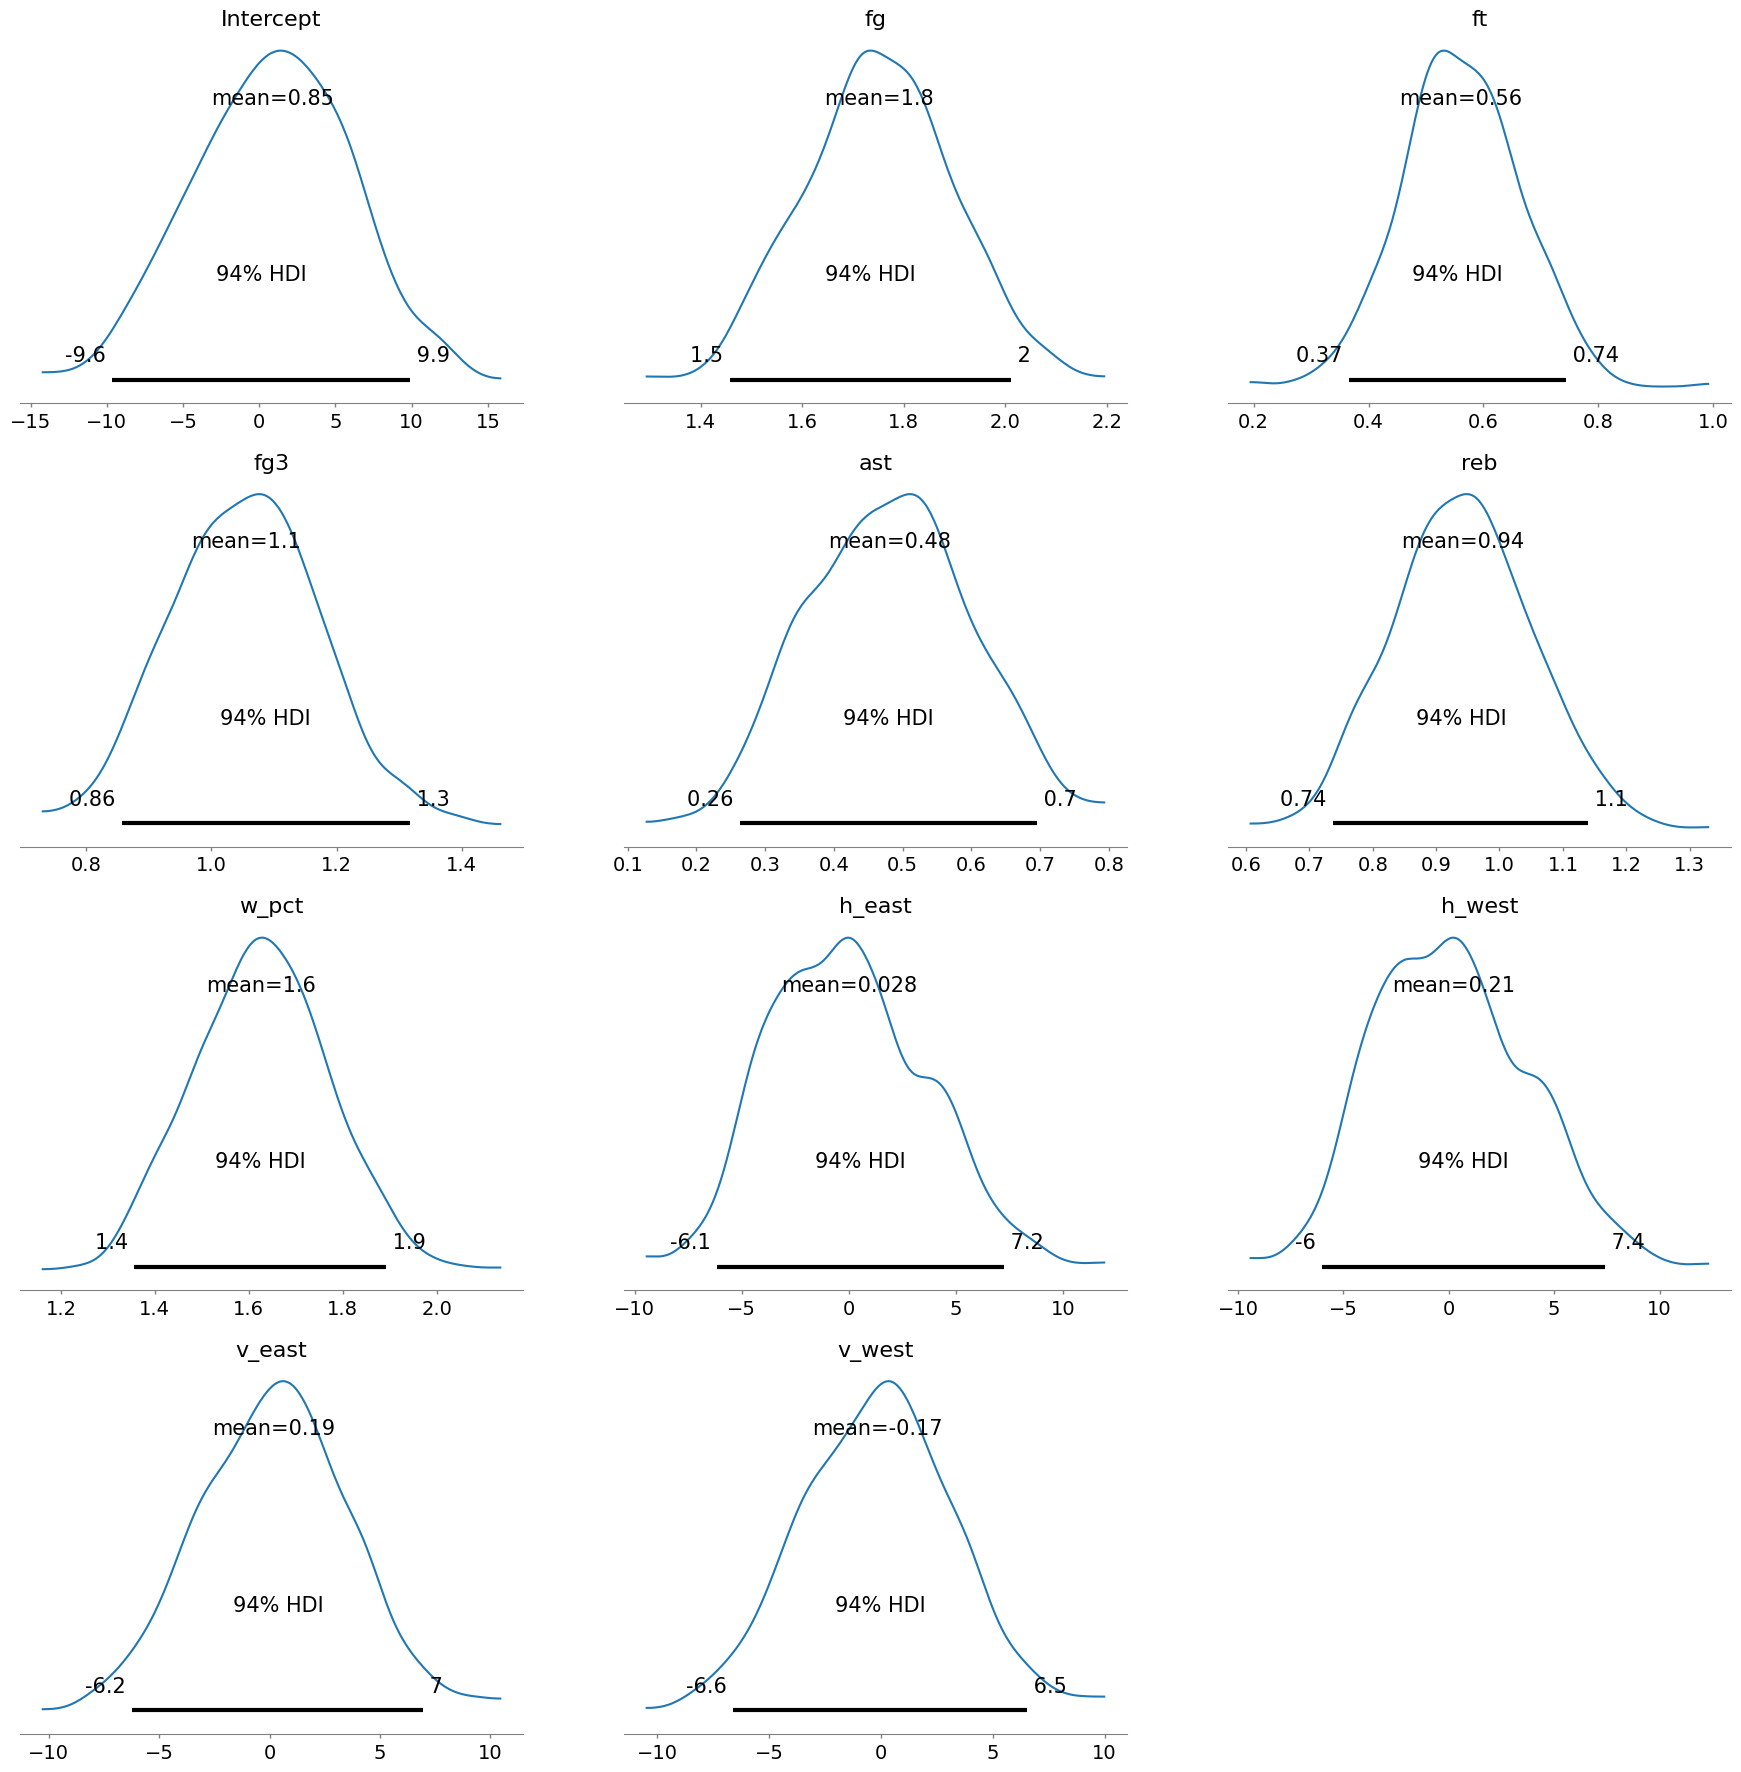

In [20]:
my_model_samples = az.convert_to_inference_data(bay_results)
az.plot_posterior(my_model_samples)
plt.show()

### Non-parametric methods

_We made a Neural Network and a Random Forest to predict our target variable. We used the same dataset as the GLMs and split the data into train and test sets of the same size to ensure consistency in comparison. We made use of these two particular methods as we wanted to see both how ensemble learning performed, and whether there were any non-linearities that could be exploited using a Neural Network._

#### Method 1: Random Forest

In [21]:
# here we make use of our diff dataset to predict the outcome of a game using a random
# forest classifier
df_random_forest = df_transformed.copy()
y = df_random_forest.pop('HOME_TEAM_WINS')
X = df_random_forest

# splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# defining the rf classifier and calculating the total runtime
random_forest = RandomForestClassifier(random_state=42)
start = time.time()
random_forest.fit(X_train, y_train)

# making predictions and calculating different evaluation metrics
y_pred_rf = random_forest.predict(X_test)
end = time.time()
print(f"Runtime: {end - start} seconds")

Runtime: 1.3291449546813965 seconds


In [23]:
# all my evaluation metrics
rmse_rf = np.sqrt(np.mean((y_pred_rf - y_test)**2))
acc_rf= accuracy_score(y_test, y_pred_rf)

In [24]:
print(f'{"Testing RMSE:":<20} {rmse_rf:.4f}')
print(f'{"Accuracy:":<20} {acc_rf:.2%}')
print(f'{"Classification Report":=^40}')
print(classification_report(y_test, y_pred_rf))

Testing RMSE:        0.3610
Accuracy:            86.97%
=========Classification Report==========
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3230
           1       0.89      0.89      0.89      4772

    accuracy                           0.87      8002
   macro avg       0.86      0.86      0.86      8002
weighted avg       0.87      0.87      0.87      8002



#### Method 2: Neural Networks

In [25]:
# similar to rf, we use the diff dataset to predict the outcome of a game using a neural
# network classifier
df_nn = df_transformed.copy()
y = df_nn.pop('HOME_TEAM_WINS')
X = df_nn

# splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
# first i define the nn classifier, a multilayer perceptron
mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000, random_state=42)
start = time.time()
mlp.fit(X_train, y_train)

# making predictions
y_pred_mlp = mlp.predict(X_test)
end = time.time()
print(f"Runtime: {end - start} seconds")

Runtime: 31.59515380859375 seconds


In [27]:
# all my evaluation metrics
rmse_mlp = np.sqrt(np.mean((y_pred_mlp - y_test)**2))
acc_mlp = accuracy_score(y_test, y_pred_mlp)

In [28]:
print(f'{"Testing RMSE:":<20} {rmse_mlp:.4f}')
print(f'{"Accuracy:":<20} {acc_mlp:.2%}')
print(f'{"Classification Report":=^40}')
print(classification_report(y_test, y_pred_mlp))

Testing RMSE:        0.4153
Accuracy:            82.75%
=========Classification Report==========
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      3230
           1       0.87      0.83      0.85      4772

    accuracy                           0.83      8002
   macro avg       0.82      0.83      0.82      8002
weighted avg       0.83      0.83      0.83      8002

